### Project: Income Qualification - Random Forest

Many social programs have a hard time making sure the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to classify them and predict their level of need. While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB)believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance. 

#### Following actions should be performed:

* Identify the output variable.

* Understand the type of data.

* Check if there are any biases in your dataset.

* Check whether all members of the house have the same poverty level.

* Check if there is a house without a family head.

* Set poverty level of the members and the head of the house within a family.

* Count how many null values are existing in columns.

* Remove null value rows of the target variable.

* Predict the accuracy using random forest classifier.

* Check the accuracy using random forest with cross validation.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline

In [2]:
os.chdir('C:\\DATA\\Project')

In [3]:
DF_Train = pd.read_csv('train.csv')
DF_Test = pd.read_csv('test.csv')

#### 1. Identify the output variable.

In [4]:
train_col = list(DF_Train.columns)
test_col = list(DF_Test.columns)
target_var = list(set(train_col) - set(test_col))
print(target_var)

['Target']


In [5]:
# Description of target variable
dictOfTargets = {1: "very low income", 2:"low income", 3:"medium income", 4:"high income"}
df = pd.DataFrame(list(dictOfTargets.items()),columns = ['Target','Variable description'],index = None)
df.style.hide_index()

Target,Variable description
1,very low income
2,low income
3,medium income
4,high income


#### 2. Understand the type of data.

In [7]:
DF_Train.shape

(9557, 143)

In [8]:
DF_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [9]:
column_types = DF_Train.dtypes
Objects = column_types[column_types == 'object'].index
Floats = column_types[column_types == 'float64'].index
Ints = column_types[column_types == 'int64'].index

In [10]:
print("{}\n\n".format(list(Objects)))
print("{}\n\n".format(list(Floats)))
print("{}\n\n".format(list(Ints)))

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']


['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'overcrowding', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned']


['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera', 'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'd

#### 3. Check if there are any biases in your dataset.

In [11]:
# Turn off scientific notation
pd.options.display.float_format = '{:.2f}'.format
DF_Train['v2a1'].describe()

count      2697.00
mean     165231.61
std      150457.13
min           0.00
25%       80000.00
50%      130000.00
75%      200000.00
max     2353477.00
Name: v2a1, dtype: float64

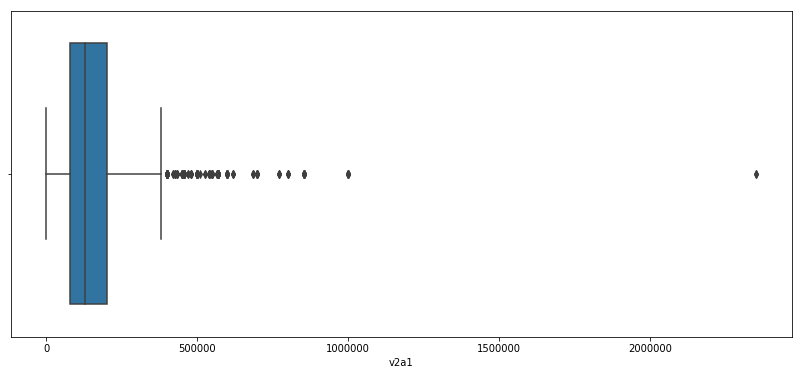

In [12]:
# bias found in column variable - v2a1 (Monthly rent payment)
plt.figure(figsize=(14, 6))
sns.boxplot(DF_Train['v2a1'])
# outliers are occuring past the “maximum”: Q3 + 1.5*IQR 
# we see for example rent having amount of 1000000 is too high
# refer to box plot below

In [13]:
DF_Train[['Id','idhogar']].head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


From the data in the columns: Id, idhogar we can see unusual value in variable like character/char values



 #### 4. Check whether all members of the house have the same poverty level.
 
 For this problem I found some households have different target or poverty level for a subset of members.
 
 proceeded to fix the target level by setting all members of a household to the target level of the head 
 of household.

In [16]:
# lets get a general description of all households
dfg = DF_Train.groupby('idhogar')
print('There are {} households'.format(dfg.ngroups))
Households = DF_Train.groupby('idhogar')['Target'].count()
print('households with only one member: {}'.format(Households[Households == 1].count()))
print('households with more than one member: {}'.format(Households[Households > 1].count()))

There are 2988 households
households with only one member: 398
households with more than one member: 2590


In [17]:
data1 = pd.DataFrame(DF_Train.groupby('idhogar')['Target'].unique())
data2 = pd.DataFrame(DF_Train.groupby('idhogar')['Target'].nunique())
df_data = pd.concat([data1,data2],axis=1)
df_data.head(20)

,Target,Target
idhogar,,
001ff74ca,[4],1
003123ec2,[2],1
004616164,[2],1
004983866,[3],1
005905417,[2],1
006031de3,[4],1
006555fe2,[4],1
00693f597,[4],1
006b64543,[4],1


 In household identifier 0172ab1d9: we see 2 different target value for members of a household

In [19]:
diff_target_level = data2.loc[data2['Target'] > 1]
same_target_level = data2.loc[data2['Target'] == 1]
print("Number of Households where all members do NOT have the same target level: {}".format(len(diff_target_level.index)))
print("Number of Households where all members do have the same target level: {}".format(len(same_target_level.index)))
print("We see for example the household with idhogar:{} have different target level".format(diff_target_level.index[0]))

Number of Households where all members do NOT have the same target level: 85
Number of Households where all members do have the same target level: 2903
We see for example the household with idhogar:0172ab1d9 have different target level


 Here is an example of a household where all members do NOT have the same target level

In [21]:
DF_Train[DF_Train['idhogar'] == diff_target_level.index[0]][['Id','idhogar','parentesco1','Target']]

,Id,idhogar,parentesco1,Target
7651,ID_a5e2b0639,0172ab1d9,0,3
7652,ID_5dfdf4ebe,0172ab1d9,0,2
7653,ID_762e1fd96,0172ab1d9,0,3
7654,ID_c76b87004,0172ab1d9,1,3
7655,ID_1dffe3dcf,0172ab1d9,0,2


In [22]:
for household in diff_target_level.index:
    head_target = DF_Train[(DF_Train['idhogar'] == household) & (DF_Train['parentesco1'] == 1)][['Target']]
    set_to_head = head_target.Target.item()
    DF_Train.loc[DF_Train['idhogar'] == household, 'Target'] = set_to_head
    
#DF_Train.groupby('idhogar')['Target'].unique()
# Example where target level of the members of the house within a family is set to target level of head of household
DF_Train[DF_Train['idhogar'] == diff_target_level.index[0]][['Id','idhogar','parentesco1','Target']]

,Id,idhogar,parentesco1,Target
7651,ID_a5e2b0639,0172ab1d9,0,3
7652,ID_5dfdf4ebe,0172ab1d9,0,3
7653,ID_762e1fd96,0172ab1d9,0,3
7654,ID_c76b87004,0172ab1d9,1,3
7655,ID_1dffe3dcf,0172ab1d9,0,3


#### 5. Check if there is a house without a family head.

In [24]:
head = DF_Train.groupby('idhogar')['parentesco1'].sum()

no_head = DF_Train.loc[DF_Train['idhogar'].isin(head[head == 0].index), :]
no_head_household = len(no_head.groupby('idhogar')['idhogar'].count())
print('Number of households without a family head: {}'.format(no_head_household))
# verify the households with no head of household and with head of headhold

print(len(head[head == 0]))   # no head of household
print(len(head[head == 1]))   # have head of household

Number of households without a family head: 15
15
2973


In [25]:
# for verification purposes
#DF_Train.groupby('idhogar')['Target'].nunique()
#DF_Train.groupby('idhogar')['Target'].unique()

#### 6. Set poverty level of the members and the head of the house within a family.

As discuss in class today the instructor stated the following action to take:
Document that insufficient data. As a data scientist we will in such scenarios 
explicitly reach to database teams and ask for more information sources.

#### 7. Count how many null values are existing in columns.

In [28]:
colunm_with_nulls = DF_Train.isnull().sum()
colunm_with_nulls[colunm_with_nulls > 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [29]:
# DETAILED ANALYSIS OF COLUMNS WITH NULL VALUES

# 2. v2a1, Monthly rent payment
# 9. v18q1, number of tablets household owns
# 22. rez_esc, Years behind in school
# 104. meaneduc, average years of education for adults (18+)
# 141. SQBmeaned, square of the mean years of education of adults (>=18) in household

In [30]:
# Display Columns with nan(null) values

In [31]:
DF_Train[['Id','v2a1','v18q1','rez_esc','meaneduc','SQBmeaned']].head(5)

,Id,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,ID_279628684,190000.00,nan,nan,10.00,100.00
1,ID_f29eb3ddd,135000.00,1.00,nan,12.00,144.00
2,ID_68de51c94,nan,nan,nan,11.00,121.00
3,ID_d671db89c,180000.00,1.00,1.00,11.00,121.00
4,ID_d56d6f5f5,180000.00,1.00,nan,11.00,121.00


In [32]:
DF_Train.loc[DF_Train['meaneduc'].isnull()][['Id','meaneduc','SQBmeaned']]

,Id,meaneduc,SQBmeaned
1291,ID_bd8e11b0f,nan,nan
1840,ID_46ff87316,nan,nan
1841,ID_69f50bf3e,nan,nan
2049,ID_db3168f9f,nan,nan
2050,ID_2a7615902,nan,nan


In [33]:
DF_Train[DF_Train['v2a1'].isnull()].shape

(6860, 143)

In [34]:
# 2. v2a1, Monthly rent payment
# Find all rows where the monthly rent column:v2a1 is null
# display the first few rows or examples with null values
idx_null = DF_Train[DF_Train['v2a1'].isnull()].index
rent_related_col = ['Id','v2a1','tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']
rent_status = DF_Train.loc[idx_null,rent_related_col]
rent_status.head()

,Id,v2a1,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
2,ID_68de51c94,nan,1,0,0,0,0
13,ID_064b57869,nan,1,0,0,0,0
14,ID_5c837d8a4,nan,1,0,0,0,0
26,ID_e5cdba865,nan,1,0,0,0,0
32,ID_e24d9c3c9,nan,1,0,0,0,0


In [35]:
# Set null values for v2a1 or monthly rent to 0
DF_Train['v2a1'].fillna(value=0, inplace=True)

In [36]:
#  9. v18q1, number of tablets household owns

In [37]:
tablet_status = DF_Train.groupby('v18q')[['v18q','v18q1']]
print(DF_Train.groupby('v18q')['v18q1'].count())
tablet_status.head()

v18q
0       0
1    2215
Name: v18q1, dtype: int64


,v18q,v18q1
0,0,nan
1,1,1.00
2,0,nan
3,1,1.00
4,1,1.00
5,1,1.00
6,1,1.00
7,0,nan
8,0,nan
9,0,nan


In [38]:
DF_v18q1_null = DF_Train[DF_Train['v18q1'].isnull()]
DF_v18q1_null.groupby('v18q').count()['v2a1']

v18q
0    7342
Name: v2a1, dtype: int64

In [39]:
# After grouping the data rows or households into 2 groups: households that does not own a tablet (v18q=0) 
# and households that does own a tablet (v18q=1), it is clear that the null values are coming from household that
# does not own a tablet
DF_Train['v18q1'].fillna(value=0,inplace=True)

In [40]:
# 22. rez_esc, Years behind in school
# This column will need to be drop
DF_Train.drop(columns = 'rez_esc',inplace=True)

In [41]:
# 104. meaneduc, average years of education for adults (18+)
# 141. SQBmeaned, square of the mean years of education of adults (>=18) in household

In [42]:
# use median value for null values
Median1 = int(DF_Train['meaneduc'].median())
Median2 = int(DF_Train['SQBmeaned'].median())
DF_Train[['meaneduc']] = DF_Train[['meaneduc']].fillna(Median1)
DF_Train[['SQBmeaned']] = DF_Train[['SQBmeaned']].fillna(Median2)

In [43]:
DF_Train[['dependency','edjefe','edjefa']].tail(6)

,dependency,edjefe,edjefa
9551,yes,no,no
9552,.25,9,no
9553,.25,9,no
9554,.25,9,no
9555,.25,9,no
9556,.25,9,no


#### 8. Remove null value rows of the target variable.

In [44]:
DF_Train['Target'].isnull().any()

False

In [45]:
DF_Train[['dependency','edjefe','edjefa']] = DF_Train[['dependency','edjefe','edjefa']].replace({'yes': 1,'no': 0})

In [68]:
DF_Train[['dependency','edjefe','edjefa']].tail(6)

,dependency,edjefe,edjefa
9551,1,0,0
9552,.25,9,0
9553,.25,9,0
9554,.25,9,0
9555,.25,9,0
9556,.25,9,0


In [47]:
columns_drop = ['Id','idhogar','SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe','SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']
DF_Train.drop(columns = columns_drop,inplace=True)
DF_Test.drop(columns = columns_drop,inplace=True)

In [48]:
# validate the number of columns before we feed it into our Random Forest algorithm
print(DF_Train.shape)

(9557, 131)


#### 9 Predict the accuracy using random forest classifier.

In [49]:
X = DF_Train.drop('Target', axis=1)
Y = DF_Train.Target

X_train, X_test, Y_train, Y_test =  train_test_split(X,Y,test_size=.30,random_state=5)

In [50]:
model = RandomForestClassifier(n_estimators=100)
RF_level = model.fit(X_train,Y_train)
Predicted  = RF_level.predict(X_test)
Predicted = pd.DataFrame(Predicted,columns=["Predict"])
FinalDB = pd.concat([(X_test.reset_index(drop=True)),(Y_test.reset_index(drop=True)),Predicted],axis=1)
FinalDB.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,Predict
0,0.00,0,5,0,1,1,0,0.00,0,2,...,0,0,0,0,0,1,0,50,4,4
1,0.00,0,6,0,1,1,1,1.00,0,0,...,0,0,0,0,0,1,0,19,4,4
2,0.00,0,6,0,1,1,0,0.00,0,3,...,0,0,0,0,0,1,0,28,2,4
3,0.00,0,5,0,1,1,0,0.00,0,1,...,0,0,1,0,0,1,0,56,2,2
4,0.00,0,5,0,1,1,0,0.00,0,2,...,0,0,0,0,0,1,0,19,4,4


In [51]:
metrics.accuracy_score(FinalDB.Target,FinalDB.Predict)

0.9236401673640168

In [52]:
Predicted.shape

(2868, 1)

In [54]:
pd.crosstab(FinalDB.Target,FinalDB.Predict)

Predict,1,2,3,4
Target,,,,
1,194,0,1,39
2,0,371,4,64
3,0,11,300,76
4,0,5,2,1801


In [55]:
from sklearn.model_selection import cross_val_score
CV = cross_val_score(RandomForestClassifier(n_estimators=100), X, Y)
CV

array([0.66370293, 0.64382845, 0.65096808, 0.46677132, 0.55206698])

In [56]:
param_grid_target = {'n_estimators':[100,150,200,250],'max_depth':[5,10,15,20],'min_samples_leaf':[1,3,5]}

In [57]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
rf_grid_output = GridSearchCV(estimator=model,param_grid=param_grid_target,cv=10)

%time rf_grid_output.fit(X_train,Y_train)

Wall time: 14min 19s


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 150, 200, 250]})

In [58]:
print(rf_grid_output.best_score_,rf_grid_output.best_params_)

0.9162813386679556 {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}


In [79]:
model = RandomForestClassifier(n_estimators=175,max_depth=20,min_samples_leaf=1)

#model = RandomForestClassifier(n_estimators=100)
RF_level = model.fit(X_train,Y_train)
Predicted  = RF_level.predict(X_test)
Predicted = pd.DataFrame(Predicted,columns=["Predict"])
FinalDB = pd.concat([(X_test.reset_index(drop=True)),(Y_test.reset_index(drop=True)),Predicted],axis=1)
metrics.accuracy_score(FinalDB.Target,FinalDB.Predict)

0.9184100418410042

#### 10. Check the accuracy using random forest with cross validation.

In [65]:
from sklearn.model_selection import KFold

CV=KFold(n_splits=10,random_state=5,shuffle=True)

rfClassifier=RandomForestClassifier(random_state=10,n_jobs=-1)
score = cross_val_score(rfClassifier,X,Y,cv=CV,scoring='accuracy')
score

array([0.94769874, 0.95711297, 0.94560669, 0.96338912, 0.95711297,
       0.95502092, 0.95711297, 0.96230366, 0.94554974, 0.95078534])

In [66]:
np.mean(score)

0.9541693136760937

 As per above results accuracy is improving substantially, so we are fine with the final results and we have validated with cross validation that
 the selected model is in sync